# Name Encoder-Decoder

Let's do the same exercise again, but now instead of an RNN whose output layer gives the (log) probability that a name belongs to a particular country, let's have an encoder-decoder spell out the name of the country!

We'll use the same names data set, where each name has been tokenized, converted into a vocabulary index, and sandwiched in <SOS>/<EOS> tokens. But now we'll use a verision of the country labels where they have undergone the same processing, rather than being converted to an index of a one-hot encoding.

## Libraries

In [1]:
import os
import numpy as np
import yaml

import torch
import lightning as L
from lightning.pytorch.loggers import TensorBoardLogger
from pytorch_lightning import seed_everything

from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

import matplotlib.pyplot as plt

from common.language import load_language

from common.dataloaders import (
    TranslationDataset,
    padding_collator,
)

from common.models import (
    EncoderDecoder,
)

from common.utils import (
    get_logger,
    Timer,
)

logger = get_logger("name_classification")

## Parameters

In [2]:
seed_everything(2718)

# Set the cwd to the root of the project.
# Only let this execute once
if os.getcwd().endswith("src"):
    os.chdir("..")

logger.info(f"Current working directory: {os.getcwd()}")

2024-10-14 21:00:30 - name_classification - INFO: Current working directory: /home/rob/encoder-decoder


In [3]:
# Load config.yaml. This contains all of our paths and constants.
with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)

# Training params
EPOCHS = 10
BATCH_SIZE = 128
EMBEDDING_SIZE = 512
HIDDEN_SIZE = 512
NUM_LAYERS = 1
DROPOUT = 0.0 # Dropout is between rnn layers

# No unit type option here, just using GRUs.

# Trainer params
ACCELERATOR = "gpu"  # "cpu" or "gpu"

# CPUS to give each dataloader
NUM_WORKERS = 3

# Every time you run training, the logs will have this tag attached.
# If you rerun with the same tag, the log will be overwritten.
TAG = (
    f"encoder-decoder_"
    f"BATCH_SIZE={BATCH_SIZE}_"
    f"EMBEDDING_SIZE={EMBEDDING_SIZE}_"
    f"HIDDEN_SIZE={HIDDEN_SIZE}_"
    f"LAYERS={NUM_LAYERS}_"
    f"DROPOUT={DROPOUT}_"
)

In [4]:
# Same names language model
names_language = load_language(config["NAMES_LANGUAGE_MODEL_PATH"])

# Now use the language model that tokenizes the country as letters and adds a start and end token
countries_language = load_language(config["COUNTRIES_LETTER_LANGUAGE_MODEL_PATH"])

In [5]:
NAMES_VOCAB_SIZE = len(names_language.vocabulary)
COUNTRIES_VOCAB_SIZE = len(countries_language.vocabulary)

print(f"Names vocab size: {NAMES_VOCAB_SIZE}")
print(f"Countries vocab size: {COUNTRIES_VOCAB_SIZE}")

# Vocabulary attributes are a dictionary with the token being the
# key and the index being how frequently the token appears in the corpus.
# Note that since we've added the special tokens ourselves, they will
# have frequency 0.
name_vocab = list(names_language.vocabulary.keys())
country_vocab = list(countries_language.vocabulary.keys())

print("Top 10 most common tokens in names vocabulary:")
for i in range(10):
    print(f"{name_vocab[i]}: {names_language.vocabulary[name_vocab[i]]}")

print("\nTop 10 most common tokens in countries vocabulary:")
for i in range(10):
    print(
        f"{country_vocab[i]}: {countries_language.vocabulary[country_vocab[i]]}"
    )

Names vocab size: 91
Countries vocab size: 35
Top 10 most common tokens in names vocabulary:
<PAD>: 0
<UNK>: 0
<SOS>: 0
<EOS>: 0
a: 11339
o: 8849
i: 8625
e: 8359
n: 8158
r: 6841

Top 10 most common tokens in countries vocabulary:
<PAD>: 0
<UNK>: 0
<SOS>: 0
<EOS>: 0
i: 16895
n: 16510
s: 15251
a: 14297
u: 9779
R: 9408


## Dataset and Dataloader

In [6]:
dataset = TranslationDataset(
    source_labels_path=config["NAMES_INPUT_PATH"],
    target_labels_path=config["COUNTRIES_INPUT_PATH"],
    source_indices_path=config["NAMES_OUTPUT_PATH"],
    target_indices_path=config["COUNTRIES_LETTER_OUTPUT_PATH"],
)

In [7]:
# Show random example
x, y, name, country = dataset[np.random.randint(0, len(dataset))]
print("Input: ", x)
print("Target: ", y)
print("Name: ", name)
print("Country: ", country)

# Note that both source and target languages have <SOS> and  <EOS> tokens now.

Input:  tensor([ 2, 39,  4,  8,  7,  3])
Target:  tensor([ 2, 13,  5, 12, 11,  4,  6, 10,  3])
Name:  Vane
Country:  English


In [8]:
train_data, val_data = torch.utils.data.random_split(dataset, [0.8, 0.2])

In [9]:
# Create the dataloaders
# We use a collate function to pad the sequences to the same length.

train_dataloader = torch.utils.data.DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    collate_fn=padding_collator,
)

val_dataloader = torch.utils.data.DataLoader(
    val_data,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    collate_fn=padding_collator,
)

In [10]:
# Inspect the data loader.

x, y, names, countries = next(iter(train_dataloader))
print("Source shape: ", x.shape)
print("Target shape: ", y.shape)


# Just to be sure, detokenize the first row
print("\nDetokenize the first row")
print("Source: ", names_language.index_to_token(x[0]))
print("Target: ", countries_language.index_to_token(y[0]))

Source shape:  torch.Size([128, 19])
Target shape:  torch.Size([128, 12])

Detokenize the first row
Source:  ['<SOS>', 'M', 'i', 'h', 'e', 'i', 'k', 'i', 'n', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
Target:  ['<SOS>', 'R', 'u', 's', 's', 'i', 'a', 'n', '<EOS>', '<PAD>', '<PAD>', '<PAD>']


## Model

In [11]:
model = EncoderDecoder(
    source_language=names_language,
    target_language=countries_language,
    detokenizer=lambda s: "".join(s),
    input_size=NAMES_VOCAB_SIZE,
    output_size=COUNTRIES_VOCAB_SIZE,
    embedding_size=EMBEDDING_SIZE,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT,
    epochs=EPOCHS,
    data_length=len(train_data),
    max_output_length=20,
)



In [12]:
# Check that we can forward pass with the x,y generated above.

context_vector = model.encoder_step(x)
print(f"Context vector shape: {context_vector.shape}")

output, hidden = model.decoder_step(y[:, :-1], context_vector, context_vector)
print(f"Output shape: {output.shape}")
print(f"Hidden shape: {hidden.shape}")

Context vector shape: torch.Size([1, 128, 512])
Output shape: torch.Size([128, 11, 35])
Hidden shape: torch.Size([1, 128, 512])


In [13]:
# Print how many parameters the model has
print(
    f"Model has {sum(p.numel() for p in model.parameters() if p.requires_grad):,} parameters."
)

Model has 4,282,915 parameters.


## Training

In [14]:
# Training logs

tensorboard_logger = TensorBoardLogger(
    save_dir=config["TENSORBOARD_LOGS_PATH"],
    name="name-encoder-decoder/",
    version=TAG,
)

In [15]:
# Use our nominated accelerator and log to tensorboard
trainer = L.Trainer(
    devices=1,
    accelerator=ACCELERATOR,
    logger=tensorboard_logger,
    max_epochs=EPOCHS,
)

In [16]:
timer = Timer()
trainer.fit(model, train_dataloader, val_dataloader)
print(f"Elapsed time: {timer.toc()}")

/home/rob/encoder-decoder/.venv/lib/python3.12/site-packages/lightning/pytorch/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 128. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 0: 100%|██████████| 126/126 [00:02<00:00, 62.98it/s, v_num=0.0_]

/home/rob/encoder-decoder/.venv/lib/python3.12/site-packages/lightning/pytorch/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 46. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 9: 100%|██████████| 126/126 [00:02<00:00, 55.04it/s, v_num=0.0_]
Elapsed time: 00:00:23


In [17]:
# Save the model
torch.save(model.state_dict(), config["NAME_ENCODER_DECODER_TORCH_MODEL_PATH"])

## Let's try it out!

In [18]:
model.freeze()

names = ["Thompson", "Jackson", "Satoshi", "Javier", "Wang", "Kim", "Lee", "Kumar", "Ericsson"]

for name in names:
    print(f"Name: {name} \t Prediction: {model.inference(name)}")

Name: Thompson 	 Prediction: English
Name: Jackson 	 Prediction: English
Name: Satoshi 	 Prediction: Japanese
Name: Javier 	 Prediction: French
Name: Wang 	 Prediction: Chinese
Name: Kim 	 Prediction: Korean
Name: Lee 	 Prediction: English
Name: Kumar 	 Prediction: Czech
Name: Ericsson 	 Prediction: English


Pretty good! Note that Indian/Nordic names don't exist in the training data.

## Accuracy

In [19]:
# Evaluate accuracy:
model.eval()
names = []
actual = []
predicted = []

for x, y, name, country in val_data:
    prediction = model.inference(name)

    names.append(name)
    actual.append(country)
    predicted.append(prediction)

In [20]:
print(classification_report(actual, predicted))

              precision    recall  f1-score   support

      Arabic       0.98      1.00      0.99       410
     Chinese       0.70      0.53      0.61        62
       Czech       0.44      0.26      0.33       106
       Dutch       0.46      0.58      0.51        60
     English       0.79      0.74      0.76       762
      French       0.20      0.44      0.27        45
      German       0.50      0.55      0.52       146
       Greek       0.45      0.73      0.56        37
       Irish       0.42      0.46      0.44        50
     Italian       0.63      0.74      0.68       143
    Japanese       0.90      0.86      0.88       196
      Korean       0.50      0.11      0.18        18
      Polish       0.64      0.42      0.51        33
  Portuguese       0.00      0.00      0.00        12
     Russian       0.92      0.95      0.94      1838
    Scottish       0.00      0.00      0.00        26
     Spanish       0.51      0.36      0.42        58
  Vietnamese       0.25    

/home/rob/encoder-decoder/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/rob/encoder-decoder/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/rob/encoder-decoder/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

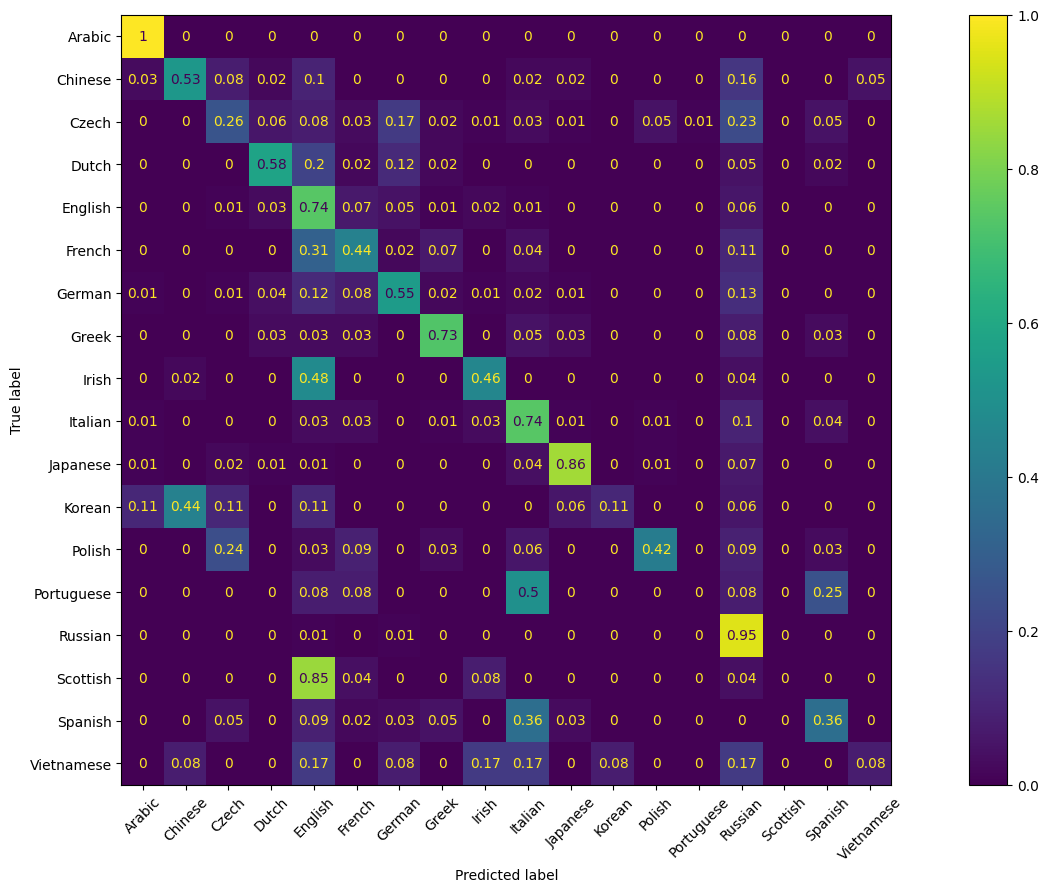

In [21]:
labels = sorted(list(set(actual).union(set(predicted))))
cm = confusion_matrix(actual, predicted, labels=labels, normalize="true")
cm = np.round(cm, 2)

plt.figure(figsize=(20, 10))
ax = plt.gca()

ConfusionMatrixDisplay(cm, display_labels=labels).plot(ax=ax)
plt.xticks(rotation=45)

plt.show()